# Обучение модели ai-forever/ruRoberta-large для multi-label классификации

In [1]:
!pip install pandas scikit-learn transformers optuna scikit-multilearn openpyxl matplotlib -q 

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report
from skmultilearn.model_selection import iterative_train_test_split
import joblib
import transformers
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
import json
import math
import gc

# Проверка версий библиотек
print("transformers version:", transformers.__version__)
print("NumPy version:", np.__version__)
print("Optuna version:", optuna.__version__)
print("Matplotlib version:", matplotlib.__version__)  


transformers version: 4.51.3
NumPy version: 1.23.5
Optuna version: 4.3.0
Matplotlib version: 3.10.1


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [4]:
# Загрузка датасета
data_path = "../data/processed/final.xlsx"
df = pd.read_excel(data_path)

# Посмотрим на первые строки и общую информацию
print("Размер датасета:", df.shape)
df.head(5)


Размер датасета: (4984, 9)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Определяем список тематик (берем из колонок кроме full_text)
all_columns = list(df.columns)
label_cols = [col for col in all_columns if col not in ('full_text', 'Unnamed: 0')]
print("Колонки тем:", label_cols)
num_topics = len(label_cols)
print("Количество тем:", num_topics)


Колонки тем: ['Спорт', 'Личная жизнь', 'Юмор', 'Соцсети', 'Политика', 'Реклама', 'Нет категории']
Количество тем: 7


In [6]:
# Преобразуем вероятности в 0/1 при пороге 0.5
threshold = 0.5
df_labels = (df[label_cols] >= threshold).astype(int)

# Добавим бинарные метки к таблице (для ясности, необязательно)
for col in label_cols:
    df[f"{col}_label"] = df_labels[col]

# Посмотрим фрагмент обновленных данных
df.head(5)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории,Спорт_label,Личная жизнь_label,Юмор_label,Соцсети_label,Политика_label,Реклама_label,Нет категории_label
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0,0,0,0,1,0,1,0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [7]:
# Количество текстов, содержащих каждую тему (частота меток)
label_counts = df_labels.sum()
print("Число текстов по темам:")
print(label_counts)

# Среднее и распределение числа тем на текст
labels_per_text = df_labels.sum(axis=1)
print("\nРаспределение числа меток на текст:")
print(labels_per_text.value_counts(), "\nСреднее:", labels_per_text.mean())


Число текстов по темам:
Спорт            1590
Личная жизнь      743
Юмор              892
Соцсети          1345
Политика          573
Реклама           571
Нет категории     593
dtype: int64

Распределение числа меток на текст:
1    3611
2    1348
0      25
Name: count, dtype: int64 
Среднее: 1.2654494382022472


In [8]:
# Преобразуем данные для разделения
X = df['full_text'].values.reshape(-1, 1)   
Y = df_labels.values                        

# Выполняем стратифицированное разделение на train/val
test_size = 0.2
X_train, y_train, X_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)

# Преобразуем обратно в списки/таблицы
train_texts = X_train.ravel()   # превращаем (n,1) обратно в (n,)
val_texts = X_val.ravel()
train_labels = y_train
val_labels = y_val

print(f"Обучающая выборка: {len(train_texts)} текстов")
print(f"Валидационная выборка: {len(val_texts)} текстов")


Обучающая выборка: 3987 текстов
Валидационная выборка: 997 текстов


In [9]:
train_label_freq = train_labels.mean(axis=0)
val_label_freq = val_labels.mean(axis=0)
freq_df = pd.DataFrame({'train_frac': train_label_freq, 'val_frac': val_label_freq}, index=label_cols)
print("Доля положительных примеров по темам в выборках:")
print(freq_df)


Доля положительных примеров по темам в выборках:
               train_frac  val_frac
Спорт            0.319037  0.318957
Личная жизнь     0.148984  0.149448
Юмор             0.179082  0.178536
Соцсети          0.269877  0.269809
Политика         0.114873  0.115346
Реклама          0.114623  0.114343
Нет категории    0.118886  0.119358


In [10]:
model_name = "ai-forever/ruRoberta-large"
#model_name = "cointegrated/rubert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
num_labels = num_topics  # количество тем
# Создаем сопоставление индексов и названий тем
id2label = {i: label for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in id2label.items()}

# Загружаем модель для классификации
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
print("Модель загружена. Число классов:", model.config.num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена. Число классов: 7


In [12]:
print("torch version:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя устройства:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Вычислительное устройство:", device)
!nvidia-smi

torch version: 2.5.1
CUDA доступна: True
Имя устройства: NVIDIA GeForce RTX 3080 Ti
Вычислительное устройство: cuda
Sat Apr 26 14:32:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   41C    P2             33W /  400W |    1623MiB /  12288MiB |     31%      Default |
|                       

In [13]:
# Токенизация текстов
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128)

# Проверим пример токенизации
print(train_texts[0])
print(train_encodings['input_ids'][0][:20], "...", "длина:", len(train_encodings['input_ids'][0]))


лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с персидского «новый день»). если вы родились 5 января 1976 года, то смотрите себя 1975 годом. так как год в этом летоисчислении начинается весной. для информации: «наступающий 2024 год пройдет под управлением грациозного, элегантного лебедя. этот год будет связан с духовным объединением людей. пришло время подняться над материальным миром, воспарить! пора понять, что не хлебом единым жив человек. и еще, верность семье будет самым главным достоинством в глазах тотема. если вы обладаете этим даром 

In [14]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Некоторые токенизаторы не выдают token_type_ids для моделей типа RoBERTa, поэтому проверим
        if 'token_type_ids' in item and item['token_type_ids'].ndim == 1:
            # Делаем token_type_ids того же измерения, что и input_ids
            item['token_type_ids'] = item['token_type_ids'].unsqueeze(0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Создаем объекты Dataset
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

print("Пример батча:")
for i in range(2):
    example = train_dataset[i]
    print(tokenizer.decode(example['input_ids']), "-- метки:", example['labels'].numpy())


Пример батча:
<s>лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с</s> -- метки: [0. 0. 0. 0. 0. 1. 0.]
<s>славянский зодиак  для познания себе, если еще мозг не закипел, ознакомьтесь с собой по дням и месяцам славянского зодиака. каждому месяцу в году и дате рождения соответствовало определенное животное. считалось, что люди, рожденные в этом месяце, обладали качествами этого животного. тотемы животных влияли на судьбу человека. таких животных 12, хотя есть предположение, что первоначально их было больше. самый древний славянский животный горо

In [15]:

def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()
    # Выбираем значения гиперпараметров из заданных диапазонов
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    #batch_size = trial.suggest_categorical('batch_size', [4, 8])
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    num_epochs = trial.suggest_int('num_epochs', 3, 6)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)
    
    # Инициализируем новую модель с исходными (pretrained) весами для данного trial
    model_trial = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_labels, 
        problem_type="multi_label_classification",
        id2label=id2label,
        label2id=label2id
    )
    model_trial.to(device)
    
    # Параметры обучения
    args = TrainingArguments(
        output_dir="optuna_trial",       # временная директория для вывода (можно переиспользовать)
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        metric_for_best_model="f1_micro",
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        # Отключаем сохранения и подробный лог
        save_strategy="no",
        logging_strategy="no",
        # Отключаем прогресс-бар для ускорения вывода
        disable_tqdm=True,
        # Используем GPU и смешанную точность
        dataloader_pin_memory=True,
        fp16=True,
        seed=SEED
    )
    
    # Создаем Trainer
    trainer = Trainer(
        model=model_trial,
        args=args,
        train_dataset=train_dataset,
        # Оценку на валидации проведём вручную после обучения
        # (чтобы сэкономить время, не делаем eval на каждой эпохе)
    )
    
    # Обучаем модель
    trainer.train()
    
    # Предсказываем на валидации
    preds = trainer.predict(val_dataset)
    logits = preds.predictions  # логиты модели (до применения сигмоиды)
    # Применяем сигмоиду к логитам для получения вероятностей
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    # Бинаризуем по порогу 0.5
    y_pred = (probs >= 0.5).astype(int)
    y_true = preds.label_ids
    
    # Вычисляем micro F1 как целевую метрику
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    # Опционально: очищаем GPU память (если большие модели, чтобы не накапливались)
    torch.cuda.empty_cache()
    
    # Возвращаем значение, которое хотим **максимизировать**
    return f1_micro

In [16]:
# Создаем исследование Optuna
study = optuna.create_study(direction='maximize', study_name="Multilabel_Optimization")
# Запускаем поиск 
study.optimize(objective, n_trials=100)

print("Наилучшее значение F1 (micro) на валидации: {:.4f}".format(study.best_value))
print("Лучшие гиперпараметры:", study.best_params)


[I 2025-04-26 14:32:10,700] A new study created in memory with name: Multilabel_Optimization
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'train_runtime': 175.1384, 'train_samples_per_second': 113.824, 'train_steps_per_second': 7.137, 'train_loss': 0.1771325439453125, 'epoch': 5.0}


[I 2025-04-26 14:35:09,552] Trial 0 finished with value: 0.7406800491601803 and parameters: {'learning_rate': 1.164738578432599e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.029633200073576883}. Best is trial 0 with value: 0.7406800491601803.


Наилучшее значение F1 (micro) на валидации: 0.7407
Лучшие гиперпараметры: {'learning_rate': 1.164738578432599e-05, 'batch_size': 16, 'num_epochs': 5, 'weight_decay': 0.029633200073576883}


In [17]:
# Сохраняем объект Optuna study в файл
joblib.dump(study, "../configs/optuna_study.pkl")

# Сохраняем лучшие гиперпараметры в JSON
best_params = study.best_params
best_params['best_val_microF1'] = study.best_value
with open("../configs/best_hyperparams.json", "w") as f:
    #import json
    json.dump(best_params, f, indent=4)


In [18]:
# Извлекаем лучшие гиперпараметры
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_lr = best_params['learning_rate']
best_epochs = best_params['num_epochs']
best_wd = best_params['weight_decay']

# Инициализируем модель с нуля (предобученные веса)
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
final_model.to(device)

# Настраиваем аргументы обучения
training_args = TrainingArguments(
    output_dir="../models/final_model",
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_wd,
    logging_strategy="epoch",
    eval_strategy="no",   # Обновлено
    save_strategy="no",   # Обновлено
    fp16=True,
    seed=SEED
)

trainer_final = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=val_dataset,  # можем указать для мониторинга, но финальную оценку сделаем отдельно
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
trainer_final.train()


Step,Training Loss
250,0.322400
500,0.209100
750,0.156400
1000,0.119000
1250,0.097000


TrainOutput(global_step=1250, training_loss=0.18077166595458985, metrics={'train_runtime': 176.0474, 'train_samples_per_second': 113.237, 'train_steps_per_second': 7.1, 'total_flos': 4644591396145920.0, 'train_loss': 0.18077166595458985, 'epoch': 5.0})

In [20]:
# Сохранение обученной модели и токенизатора
trainer_final.model.save_pretrained("../models/final_model")
tokenizer.save_pretrained("../models/final_model")
print("Модель и токенизатор сохранены в ../models/final_model/")

# Внимание, модели могут занимать много места и хранятся отдельно
# https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link

Модель и токенизатор сохранены в ../models/final_model/


<h1 style="color:red;">Внимание, модели могут занимать много места и хранятся отдельно</h1>

<p><a href="https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link" target="_blank">Ссылка на модели (Google Drive)</a></p>

In [21]:
# Предсказание на валидационной выборке
preds = trainer_final.predict(val_dataset)
logits = preds.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = preds.label_ids
y_pred_05 = (probs >= 0.5).astype(int)


In [22]:
micro_f1 = f1_score(y_true, y_pred_05, average='micro')
macro_f1 = f1_score(y_true, y_pred_05, average='macro')
macro_roc_auc = roc_auc_score(y_true, probs, average='macro')
accuracy = accuracy_score(y_true, y_pred_05)

print(f"Micro F1 = {micro_f1:.3f}")
print(f"Macro F1 = {macro_f1:.3f}")
print(f"Macro ROC-AUC = {macro_roc_auc:.3f}")
print(f"Subset Accuracy = {accuracy:.3f}")


Micro F1 = 0.741
Macro F1 = 0.706
Macro ROC-AUC = 0.928
Subset Accuracy = 0.585


In [23]:
topic_report = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=False,
    zero_division=0
)
print(topic_report)

report_dict = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=True,
    zero_division=0)
# Отбираем только «настоящие» классы, исключая accuracy и усреднения
label_keys = [k for k in report_dict if k not in ("samples avg", "micro avg", "macro avg", "weighted avg")]
# Извлекаем support для каждого класса в виде списка
support_list = [report_dict[k]["support"] for k in label_keys]
print("Список поддержек:", support_list)


               precision    recall  f1-score   support

        Спорт      0.935     0.909     0.922       318
 Личная жизнь      0.627     0.530     0.575       149
         Юмор      0.776     0.758     0.767       178
      Соцсети      0.727     0.643     0.682       269
     Политика      0.807     0.800     0.803       115
      Реклама      0.617     0.693     0.653       114
Нет категории      0.647     0.462     0.539       119

    micro avg      0.768     0.715     0.741      1262
    macro avg      0.734     0.685     0.706      1262
 weighted avg      0.764     0.715     0.737      1262
  samples avg      0.783     0.751     0.748      1262

Список поддержек: [318.0, 149.0, 178.0, 269.0, 115.0, 114.0, 119.0]


In [31]:
best_thresholds = {}
best_f1_scores = []
for i, topic in enumerate(label_cols):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probs[:, i])
    # Вычисляем F1 для каждого порога
    f1_scores = []
    for p, r in zip(precision, recall):
        if p + r == 0:
            f1 = 0
        else:
            f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    best_idx = f1_scores[:-1].argmax()  # последний элемент precision/recall не имеет соотв. порога
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_f1_scores.append(best_f1)
    best_thresholds[topic] = best_thr
    print(f"Тема '{topic}': лучший порог = {best_thr:.3f}, F1 = {best_f1:.3f}")

def compute_weighted_f1(f1_per_class, support_per_class):
    total = sum(support_per_class)
    weighted_f1 = sum(f1 * support for f1, support in zip(f1_per_class, support_per_class)) / total
    return weighted_f1

weighted_f1 = compute_weighted_f1(best_f1_scores, support_list)
print(f'''
Взвешенный F1: {weighted_f1:.4f}
''')


Тема 'Спорт': лучший порог = 0.126, F1 = 0.934
Тема 'Личная жизнь': лучший порог = 0.385, F1 = 0.600
Тема 'Юмор': лучший порог = 0.720, F1 = 0.776
Тема 'Соцсети': лучший порог = 0.399, F1 = 0.691
Тема 'Политика': лучший порог = 0.490, F1 = 0.809
Тема 'Реклама': лучший порог = 0.673, F1 = 0.670
Тема 'Нет категории': лучший порог = 0.173, F1 = 0.646

Взвешенный F1: 0.7580



In [25]:
# Применяем индивидуальные пороги для каждого класса
y_pred_opt = np.zeros_like(y_pred_05)
for i, topic in enumerate(label_cols):
    thr = best_thresholds[topic]
    y_pred_opt[:, i] = (probs[:, i] >= thr).astype(int)

micro_f1_opt = f1_score(y_true, y_pred_opt, average='micro')
macro_f1_opt = f1_score(y_true, y_pred_opt, average='macro')
accuracy_opt = accuracy_score(y_true, y_pred_opt)
print(f"После калибровки порогов: micro F1 = {micro_f1_opt:.3f}, macro F1 = {macro_f1_opt:.3f}, accuracy = {accuracy_opt:.3f}")


После калибровки порогов: micro F1 = 0.758, macro F1 = 0.732, accuracy = 0.593


In [26]:
# Функция для приведения к сериализуемому виду
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.generic):  # все numpy-скаляры
        return obj.item()
    else:
        return obj

# Подготовка данных
config = {
    "model_name": model_name,
    "best_hyperparams": make_serializable(best_params),
    "thresholds": make_serializable(best_thresholds)
}

# Сохраняем в файл
with open("../configs/final_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

print("Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅")


Конфигурация с гиперпараметрами и порогами сохранена в configs/final_config.json ✅


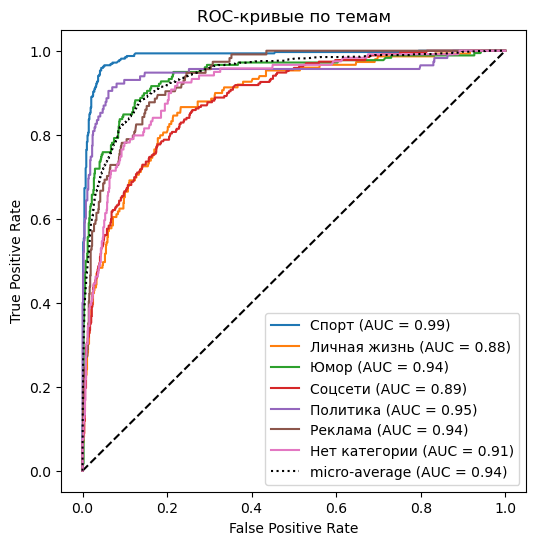

In [27]:
# Вычисляем точки для ROC-кривых
fpr = {}
tpr = {}
roc_auc = {}
for i, topic in enumerate(label_cols):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Микро-усредненная ROC (считаем как если все метки в один длинный список)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Строим график
plt.figure(figsize=(6, 6))
# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')
# Кривые по темам
for i, topic in enumerate(label_cols):
    plt.plot(fpr[i], tpr[i], label=f"{topic} (AUC = {roc_auc[i]:.2f})")
# Микро усредненная кривая
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.2f})", color='black', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по темам")
plt.legend(loc="lower right")
plt.show()


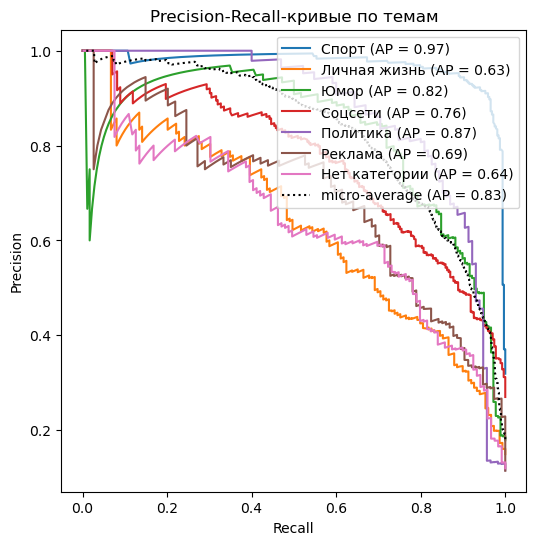

In [28]:
plt.figure(figsize=(6, 6))
for i, topic in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{topic} (AP = {pr_auc:.2f})")
# микро-усредненная PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true.ravel(), probs.ravel())
ap_micro = auc(recall_micro, precision_micro)
plt.plot(recall_micro, precision_micro, label=f"micro-average (AP = {ap_micro:.2f})", color='black', linestyle=':')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-кривые по темам")
plt.legend(loc="upper right")
plt.show()


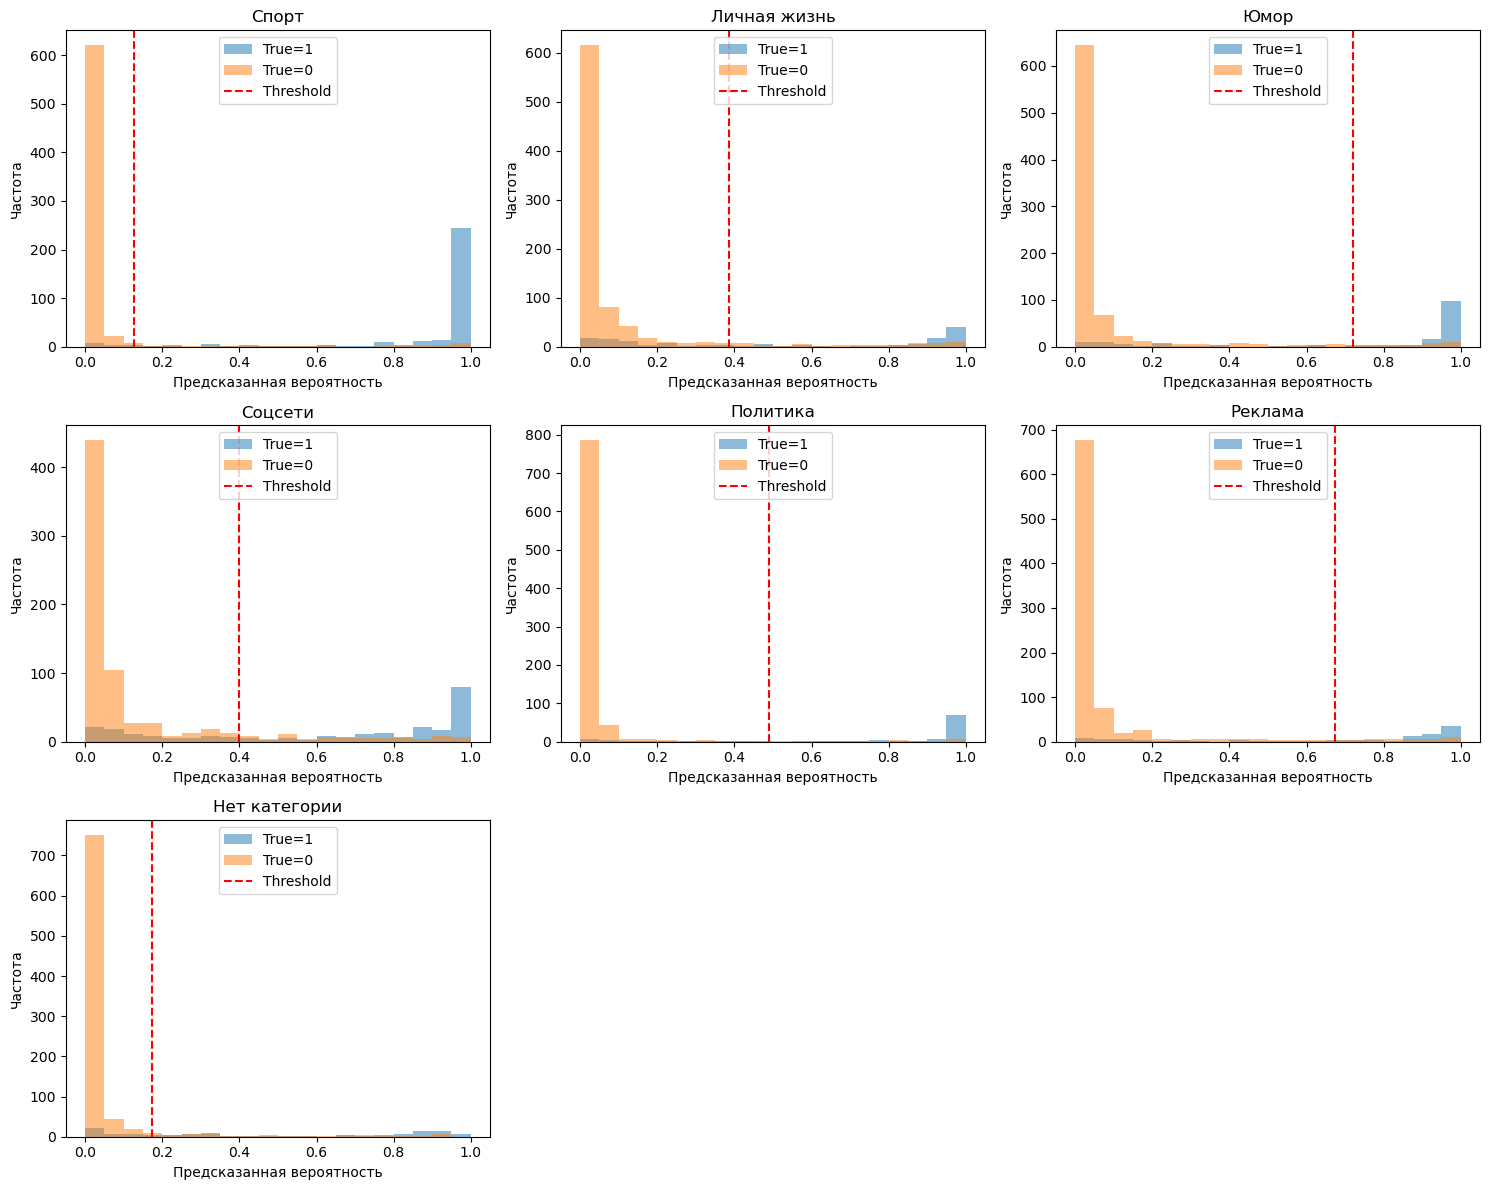

In [29]:
n_labels = len(label_cols)
n_cols = 3
n_rows = math.ceil(n_labels / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(label_cols):
    ax = axes[i]
    pos_probs = probs[y_true[:, i] == 1, i]
    neg_probs = probs[y_true[:, i] == 0, i]
    ax.hist(pos_probs, bins=20, range=(0,1), alpha=0.5, label="True=1")
    ax.hist(neg_probs, bins=20, range=(0,1), alpha=0.5, label="True=0")
    ax.axvline(best_thresholds.get(topic, 0.5), color='red', linestyle='--', label='Threshold')
    ax.set_title(topic)
    ax.set_xlabel("Предсказанная вероятность")
    ax.set_ylabel("Частота")
    ax.legend(loc="upper center")

# Отключим пустые графики если их больше, чем нужно
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

